# CIFAR100 ResNet
https://www.kaggle.com/code/minbavel/cifar-100-resnet/script

In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar100
import numpy as np
import os

**Dane**

In [2]:
batch_size = 32
epochs = 200
data_augmentation = True
num_classes = 100
subtract_pixel_mean = True
depth = 20

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


**Budowa sieci**

In [3]:
#Wspolczynnik uczenia dla epok
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

#Blok ResNet
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet(input_shape, depth, num_classes=100):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:
                strides = 2
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
model = resnet(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

In [6]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

**Trenowanie sieci**

In [7]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)
    datagen.fit(x_train)
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=2, workers=4,
                        callbacks=callbacks,steps_per_epoch=x_train.shape[0] // batch_size)

Using real-time data augmentation.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
Learning rate:  0.001
1562/1562 - 37s - loss: 3.9736 - accuracy: 0.1207 - val_loss: 3.8313 - val_accuracy: 0.1467
Epoch 2/200
Learning rate:  0.001
1562/1562 - 32s - loss: 3.2665 - accuracy: 0.2292 - val_loss: 3.3311 - val_accuracy: 0.2345
Epoch 3/200
Learning rate:  0.001
1562/1562 - 32s - loss: 2.9044 - accuracy: 0.3010 - val_loss: 3.3361 - val_accuracy: 0.2445
Epoch 4/200
Learning rate:  0.001
1562/1562 - 32s - loss: 2.6780 - accuracy: 0.3511 - val_loss: 3.1096 - val_accuracy: 0.2996
Epoch 5/200
Learning rate:  0.001
1562/1562 - 32s - loss: 2.5216 - accuracy: 0.3862 - val_loss: 2.9924 - val_accuracy: 0.3210
Epoch 6/200
Learning rate:  0.001
1562/1562 - 32s - loss: 2.3972 - accuracy: 0.4144 - val_loss: 3.0414 - val_accuracy: 0.3124
Epoch 7/200
Learning rate:  0.001
1562/1562 - 32s - loss: 2.2917 - accuracy: 0.4400 - val_loss: 2.8234 - val_accuracy: 0.3641
Epoch 8/200
Learning rate:  0.001
1562/1562 - 32s - loss: 2.2096 - accuracy: 0.4620 - val_loss: 2.6823 - val_accuracy:

Epoch 66/200
Learning rate:  0.001
1562/1562 - 32s - loss: 1.4891 - accuracy: 0.6714 - val_loss: 2.2519 - val_accuracy: 0.5422
Epoch 67/200
Learning rate:  0.001
1562/1562 - 32s - loss: 1.4846 - accuracy: 0.6716 - val_loss: 1.9654 - val_accuracy: 0.5767
Epoch 68/200
Learning rate:  0.001
1562/1562 - 32s - loss: 1.4822 - accuracy: 0.6748 - val_loss: 1.8452 - val_accuracy: 0.5975
Epoch 69/200
Learning rate:  0.001
1562/1562 - 32s - loss: 1.4861 - accuracy: 0.6736 - val_loss: 2.0397 - val_accuracy: 0.5672
Epoch 70/200
Learning rate:  0.001
1562/1562 - 32s - loss: 1.4805 - accuracy: 0.6761 - val_loss: 2.4182 - val_accuracy: 0.5103
Epoch 71/200
Learning rate:  0.001
1562/1562 - 32s - loss: 1.4739 - accuracy: 0.6746 - val_loss: 2.1200 - val_accuracy: 0.5513
Epoch 72/200
Learning rate:  0.001
1562/1562 - 32s - loss: 1.4750 - accuracy: 0.6759 - val_loss: 2.1725 - val_accuracy: 0.5485
Epoch 73/200
Learning rate:  0.001
1562/1562 - 32s - loss: 1.4659 - accuracy: 0.6783 - val_loss: 2.1736 - val_a

Epoch 134/200
Learning rate:  1e-05
1562/1562 - 32s - loss: 0.7957 - accuracy: 0.8392 - val_loss: 1.5524 - val_accuracy: 0.6683
Epoch 135/200
Learning rate:  1e-05
1562/1562 - 32s - loss: 0.7987 - accuracy: 0.8376 - val_loss: 1.5543 - val_accuracy: 0.6687
Epoch 136/200
Learning rate:  1e-05
1562/1562 - 32s - loss: 0.7949 - accuracy: 0.8379 - val_loss: 1.5586 - val_accuracy: 0.6694
Epoch 137/200
Learning rate:  1e-05
1562/1562 - 32s - loss: 0.7976 - accuracy: 0.8372 - val_loss: 1.5525 - val_accuracy: 0.6696
Epoch 138/200
Learning rate:  1e-05
1562/1562 - 32s - loss: 0.7960 - accuracy: 0.8384 - val_loss: 1.5545 - val_accuracy: 0.6702
Epoch 139/200
Learning rate:  1e-05
1562/1562 - 32s - loss: 0.7973 - accuracy: 0.8366 - val_loss: 1.5548 - val_accuracy: 0.6706
Epoch 140/200
Learning rate:  1e-05
1562/1562 - 32s - loss: 0.7934 - accuracy: 0.8384 - val_loss: 1.5513 - val_accuracy: 0.6696
Epoch 141/200
Learning rate:  1e-05
1562/1562 - 32s - loss: 0.7900 - accuracy: 0.8406 - val_loss: 1.5514

In [9]:
model.save("cifar100_resnet.h5")

In [10]:
scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 - 1s - loss: 1.5547 - accuracy: 0.6693
Test loss: 1.554701805114746
Test accuracy: 0.6693000197410583


Problem znikającego / eksplodującego gradientu - gradient zbliża się do zera lub jest za duży, zwiększa się przez to błąd testu

Sieci Residualne: Aby rozwiązać problem zanikającego/eksplodującego gradientu, sieć wprowadza - Residual Blocks. 
Pomijamy połączenia i łączymy warstwy aktywacji z kolejnymi wyrstwami. Następnie sieć jest tworzona przez warstwy kolejnych bloków. Pozwalamy sieci dopasować wagi.

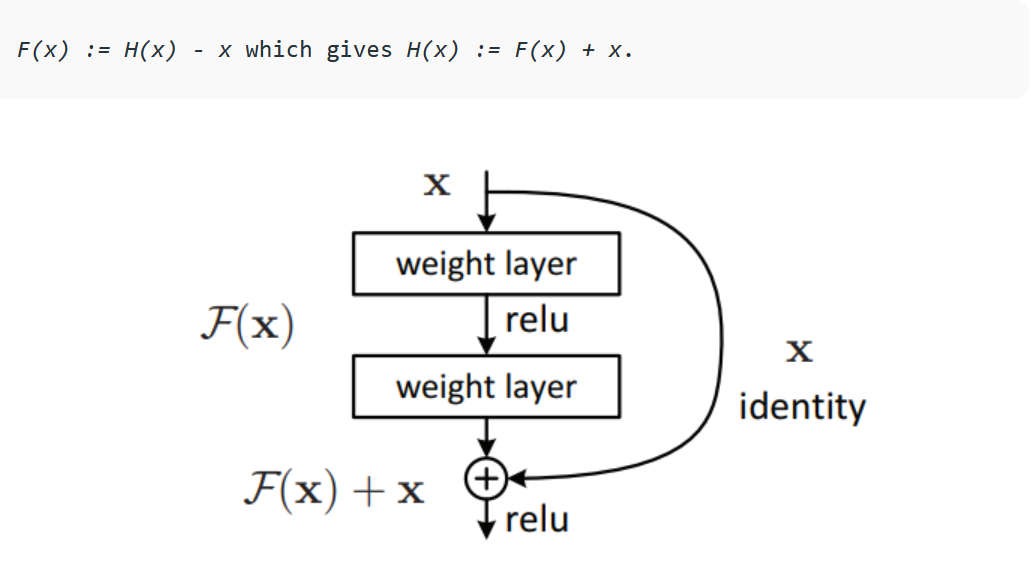

Zaleta: pomija połączenia jesli jakaś warstwa jest uszkodzona

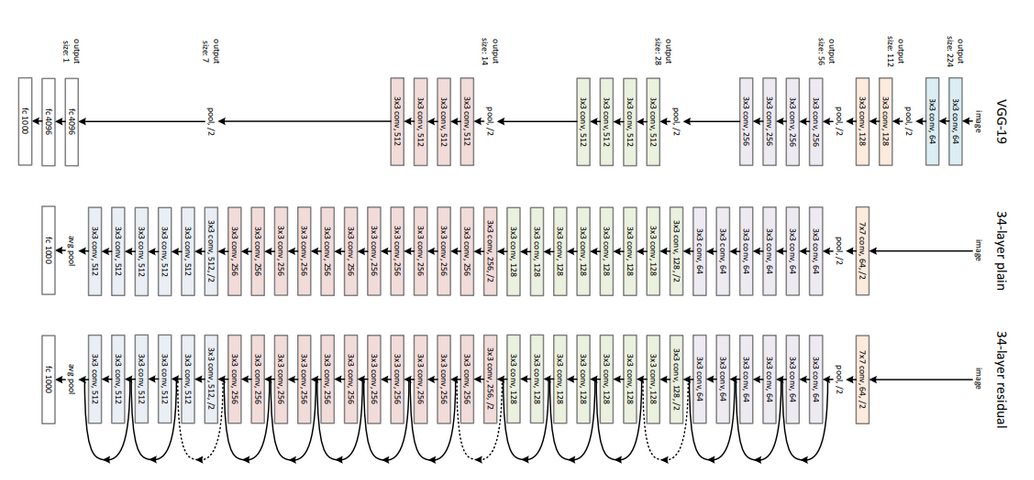

https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/